# CS/CE 457/464 - Homework Assignment 11: Deep Learning

## Name: Muhammad Areeb Kazmi
## Email ID: mk07202@st.habib.edu.pk

**Reference for Dataset:** Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

## Question 1
Select any image of your choice and apply 3 different filters on it. Display the output
for each filter.
Describe each filter, its purpose and output after applying filter. Explain if the
filter output is correctly showing its purpose.

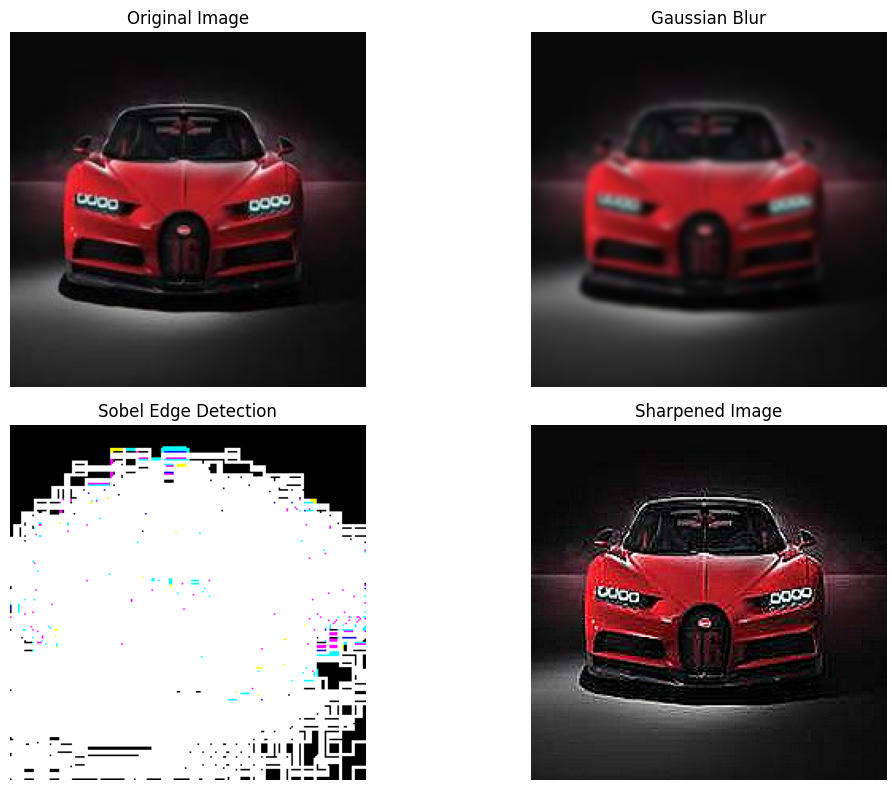

In [12]:
# Load the image
image = cv2.imread("14.jpg")

# Convert to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Gaussian Blur
gaussian_blur = cv2.GaussianBlur(image, (9, 9), 0)

# Apply Sobel Edge Detection (Horizontal and Vertical)
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)

# Apply Sharpening
kernel_sharpening = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel_sharpening)

# Convert to RGB for matplotlib display
gaussian_blur_rgb = cv2.cvtColor(gaussian_blur, cv2.COLOR_BGR2RGB)
sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

# Display original and processed images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(gaussian_blur_rgb)
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(sobel_combined, cmap="gray")
plt.title("Sobel Edge Detection")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sharpened_rgb)
plt.title("Sharpened Image")
plt.axis("off")

plt.tight_layout()
plt.show()

### Description, Purpose, and Outputs
#### Gaussian Blur:
This filter reduces image noise and detail by smoothing the image. It's commonly used in preprocessing steps to reduce high-frequency components (noise) before further processing like edge detection.
The output image did appear smoother and less detailed. The filter correctly shows its purpose by softening these features of noise in the image.

#### Sobel Edge Detection
Sobel filters detect edges by computing the gradient of the image in the horizontal (X) and vertical (Y) directions. The combined result highlights areas of high intensity change, revealing the edges.
The filtered image highlights edges in white against a dark background. Here, due to the noise, we cannot tell if the filter fulfilled its purpose

#### Sharpening
This filter enhances edges and fine details by amplifying the intensity difference around edges. It's often used to make an image appear crisper. This indeed happened and the filter fulfills its purpose.

## Question 2 a

Pick a dataset containing images of two different objects (classes) and train a deep
learning classifier on those images.
Report the best accuracy on training and validation/testing data during epochs
iterations.

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np

# Step 1: Prepare the Dataset
def get_two_classes_data(dataset, class_indices):
    """
    Filters dataset to include only specified classes.
    Args:
        dataset: The dataset to filter.
        class_indices: List of indices of the target classes.
    Returns:
        Subset of the dataset containing only specified classes.
    """
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_indices)
    filtered_indices = np.where(mask)[0]
    return Subset(dataset, filtered_indices)

# Define transforms to ensure all images are the same size
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 (CIFAR-10 size)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# Filter for classes: 0 (airplane) and 1 (car)
class_indices = [0, 1]
train_data = get_two_classes_data(train_dataset, class_indices)
test_data = get_two_classes_data(test_dataset, class_indices)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 76.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
# Step 2: Define a Simple Neural Network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes (airplane, car)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
# Step 3: Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    best_train_acc = 0.0
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        best_train_acc = max(best_train_acc, train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

    return best_train_acc, best_val_acc

# Train the model
best_train_acc, best_val_acc = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Step 4: Report Results
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/10 - Train Accuracy: 0.8417, Val Accuracy: 0.8950
Epoch 2/10 - Train Accuracy: 0.9109, Val Accuracy: 0.9370
Epoch 3/10 - Train Accuracy: 0.9373, Val Accuracy: 0.9360
Epoch 4/10 - Train Accuracy: 0.9483, Val Accuracy: 0.9445
Epoch 5/10 - Train Accuracy: 0.9577, Val Accuracy: 0.9490
Epoch 6/10 - Train Accuracy: 0.9636, Val Accuracy: 0.9510
Epoch 7/10 - Train Accuracy: 0.9695, Val Accuracy: 0.9475
Epoch 8/10 - Train Accuracy: 0.9773, Val Accuracy: 0.9540
Epoch 9/10 - Train Accuracy: 0.9818, Val Accuracy: 0.9545
Epoch 10/10 - Train Accuracy: 0.9863, Val Accuracy: 0.9535
Best Training Accuracy: 0.9863
Best Validation Accuracy: 0.9545


## Question 2 b
Get 6 new images (3 for each object/class that should not be present in your
train and test set) and test the performance of your classifier. Explain if the
classifier can accurately classify those new images.

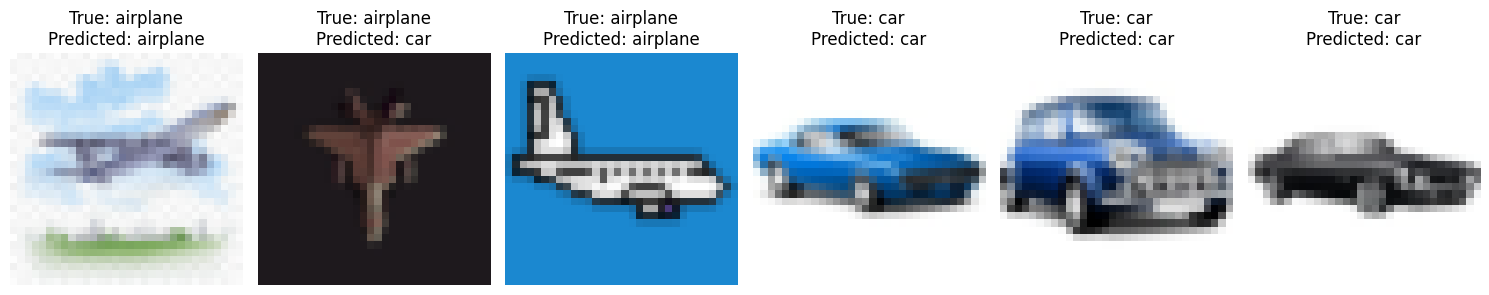

Accuracy on new images: 0.8333


In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to new images
new_images_dir = "./new_images"

# Define the mapping of classes
class_mapping = {0: "airplane", 1: "car"}

# Transformations for new images
image_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

def load_new_images(new_images_dir, class_mapping):
    """
    Loads and processes new images for testing.
    Args:
        new_images_dir (str): Path to the directory with new images.
        class_mapping (dict): Mapping of class indices to labels.
    Returns:
        List of (image, label) tuples.
    """
    new_images = []
    labels = []

    for label, class_name in class_mapping.items():
        class_dir = os.path.join(new_images_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory not found: {class_dir}")
            continue

        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                image = Image.open(file_path).convert("RGB")
                image = image_transform(image)
                new_images.append((image, file_name))
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    return new_images, labels

def test_new_images(model, new_images, labels):
    """
    Tests the classifier on new images and displays results.
    Args:
        model: Trained model.
        new_images: List of (image, filename) tuples.
        labels: List of true labels.
    """
    model.eval()
    fig, axes = plt.subplots(1, len(new_images), figsize=(15, 5))

    correct = 0
    for i, (image, file_name) in enumerate(new_images):
        # Add batch dimension
        image_tensor = image.unsqueeze(0).to(device)

        # Predict class
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)

        predicted_label = predicted.item()
        true_label = labels[i]

        # Display the image and prediction
        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # De-normalize for display
        axes[i].axis("off")
        axes[i].set_title(f"True: {class_mapping[true_label]}\nPredicted: {class_mapping[predicted_label]}")

        # Check if prediction is correct
        if predicted_label == true_label:
            correct += 1

    plt.tight_layout()
    plt.show()

    # Calculate and display accuracy
    accuracy = correct / len(new_images)
    print(f"Accuracy on new images: {accuracy:.4f}")

# Load new images
new_images, labels = load_new_images(new_images_dir, class_mapping)

# Test and display results
test_new_images(model, new_images, labels)

The clasifier correctly classified 5 out of the 6 images, where it incorrectly classified an airplane as a car, thus giving 83.33% accuracy. This has also to do with the plane being a fighter aircraft instead of an actual civilian airplane which might have confused the model. Nevertheless, this was a good result.